## Get and save train and subway rails data

Get rails data from osmnx, then filter rails only to cover area with stations using stations shapefile. Save result to railway_data as shapefile

#### Import libraries

In [1]:
# Import libraries
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS
from geopandas.tools import sjoin
import pandas as pd
import contextily as ctx
%matplotlib inline

#### Download rails in Uusimaa from osmnx

In [2]:
# Download railsdata from Uusimaa using osmnx
G = ox.graph_from_place('Uusimaa, Finland',
                        retain_all=False, truncate_by_edge=True, simplify=False,
                        network_type='none', infrastructure='way["railway"~"subway|rail"]')

# Convert multidigraph to geodataframe
nodes, edges = ox.graph_to_gdfs(G)

#### Visualize edges to see it worked

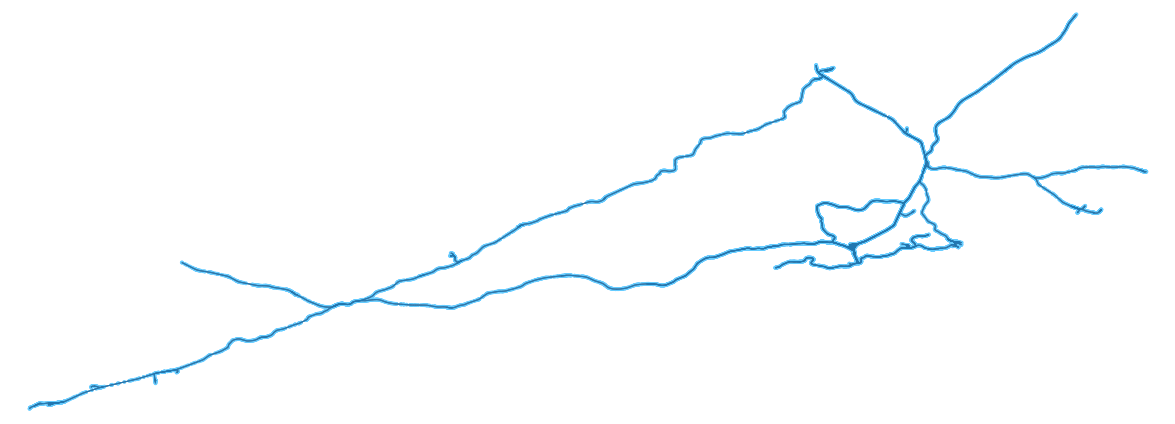

In [3]:
# Initialize figure
fig, ax = ox.plot_graph(G, show=False, close=False)

# Plot street edges
edges.plot(ax=ax, linewidth=1)

# Plot restaurants
plt.tight_layout()

#### Filter railways to cover only area with HSL train and metro stations

In [4]:
# Read stations shapefile
fp = "stations_data/stations.shp"
stations = gpd.read_file(fp)

# Create convex hull which covers all the coordinates of population data
area = stations["geometry"].unary_union.convex_hull

# Add buffer
area = area.buffer(8000)

# Simplify geometry to boost further steps
area = area.simplify(tolerance=0.005)

# Convert buffer area to geodataframe
area = pd.DataFrame({'Name': ['area'], 'geometry': area})
area = gpd.GeoDataFrame(area, geometry="geometry", crs="EPSG:3857")

# Set coordinate reference system to buffer and rail data
rails = edges.to_crs(epsg=32635)
area = area.to_crs(epsg=32635)

# Join tables to filer extra from train data
rails = gpd.sjoin(rails, area, op='within', how='inner')

# Set CRS to EPSG:3857
rails = rails.to_crs(epsg=3857)

# Print first rows of rails data
rails.head(3)

,u,v,key,osmid,tunnel,oneway,length,geometry,maxspeed,name,service,bridge,ref,index_right,Name
0,153387008,153387007,0,122595259,yes,False,72.272,"LINESTRING (2778647.324 8441808.067, 2778556.6...",NaN,NaN,NaN,NaN,NaN,0,area
1,153387008,153387010,0,122595259,yes,False,67.649,"LINESTRING (2778647.324 8441808.067, 2778744.0...",NaN,NaN,NaN,NaN,NaN,0,area
2,1074855937,418035323,0,34843849,no,False,27.028,"LINESTRING (2796766.085 8445503.693, 2796818.7...",80,NaN,NaN,NaN,NaN,0,area


#### Plot rails and stations to check that filtering railways worked

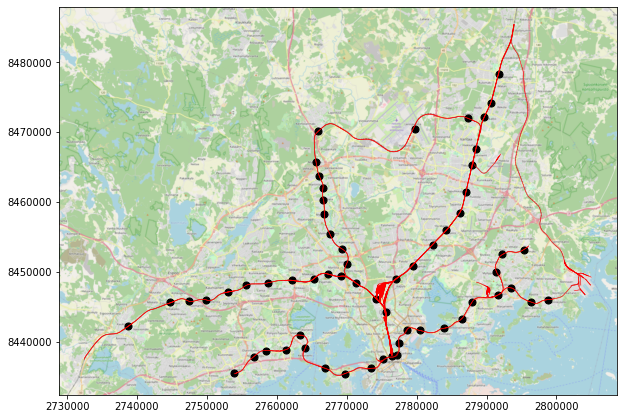

In [5]:
# Initialize the plot
fig, ax = plt.subplots(figsize=(10,10))

# Plot rails
rails.plot(ax=ax, linewidth=0.5, alpha=0.7, edgecolor='red')

# Plot stations
stations.plot(ax=ax, color="black", markersize=50)

# Add basemap with `OMS_A` style
ctx.add_basemap(ax, url=ctx.tile_providers.OSM_A)

#### Save railway data

In [6]:
# Write to Shapefile
outfp = "railway_data/railways.shp"
rails.to_file(outfp)